In [1]:
# ipython
%matplotlib inline

from IPython.display import display as d
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(rc={'figure.figsize':(12,12)})
sns.set_style("white")
import glob
import json
import os
import sys


In [10]:


#def get_ref_size(x):
#    os.system("mkdir -p yuv")
#    yuv = "yuv/" + os.path.basename(os.path.splitext(x)[0]) + ".yuv"
#    if not os.path.isfile(x):
#        print(f"{x} is not stored?!")
#        return 0
#    if not os.path.isfile(yuv):
#        os.system(f"""ffmpeg -y -i "{x}" -vframes 1 -c:v rawvideo {yuv}""")
#    return os.path.getsize(yuv)


def read_report(x):
    try:
        with open(x) as xfp:
            j = json.load(xfp)
    except:
        print(f"error with {x}")
        return {}
    t = x.split("_")
    codec = t[1]
    crf = int(t[2].replace(".json", ""))
    
    if codec == "jpg":
        ql = 1 - (crf - 1) / 99
    
    if codec == "av1" or codec == "vp9":
        ql = crf / 63
    if codec == "h264" or codec == "h265":
        ql = crf / 51
    ql = 1 - ql
    t[0] = os.path.basename(t[0])
    ext = "mkv" if codec != "jpg" else "jpg"
    
    #ref_size = get_ref_size(f"ref/{t[0]}.mkv")
    """
    if ref_size == 0:
        print(x)
        return {}
    """
    qll = 0 if codec != "jpg" else 100
    
    ref_file = f"{codec}/{t[0]}_{codec}_{qll}.{ext}"

    if not os.path.isfile(ref_file):
        return {}
     
    ref_file_size = os.path.getsize(ref_file)    
    if ref_file_size == 0:
        return {}
        
    dis_file_size = os.path.getsize(f"{codec}/{t[0]}_{codec}_{crf}.{ext}")
        
    if ref_file_size < dis_file_size:
        # this should never happen, if everything is fine with processing
        return {}
    
    res = {
        "quality_level": ql,
        "codec": codec,
        "crf": crf,
        "dis_filename": x,
        "ref_file_size": ref_file_size,
        "dis_file_size": dis_file_size,
        "image": t[0] + ".png",
        "compression_ratio": dis_file_size / ref_file_size ,
        "adm2": j["frames"][0]["metrics"]["adm2"],
        "psnr": j["frames"][0]["metrics"]["psnr"],
        "ssim": j["frames"][0]["metrics"]["ssim"],
        "vif_scale0": j["frames"][0]["metrics"]["vif_scale0"],
        "vmaf": j["frames"][0]["metrics"]["vmaf"],
    }
    return res


from multiprocessing import Pool
import multiprocessing
pool = Pool(processes=multiprocessing.cpu_count())

if not os.path.isfile("image_metrics.csv.gz"):
    # read and aggregate everything if the zip files is not there
    df = pd.DataFrame([x for x in list(pool.map(read_report, list(glob.glob("vmaf/*/*")))) if x != {}])
    for i,g in df.groupby(by="codec"):
        print(i, len(g))
    df.to_csv("image_metrics.csv.gz", index=False, compression='gzip')

error with vmaf/av1/MB5sH7a7_av1_63.json
av1 62709
h264 44555
h265 58706
jpg 113300
vp9 71899


351169 1133


,adm2,codec,compression_ratio,crf,dis_file_size,dis_filename,image,psnr,quality_level,ref_file_size,ssim,vif_scale0,vmaf
0,0.98258,vp9,0.141092,33,1441747,vmaf/vp9/WxAOzPDE_vp9_33.json,WxAOzPDE.png,44.33897,0.476190,10218464,0.99964,0.39298,97.32697
1,0.99514,vp9,0.865401,17,12028455,vmaf/vp9/rAm2NaOH_vp9_17.json,rAm2NaOH.png,50.60387,0.730159,13899277,0.99997,0.93401,99.67964
2,0.99324,vp9,0.527158,16,5466857,vmaf/vp9/SmVALmIE_vp9_16.json,SmVALmIE.png,51.04290,0.746032,10370434,0.99992,0.88596,99.12573
3,0.95160,vp9,0.017225,52,217692,vmaf/vp9/Q1fCvwaw_vp9_52.json,Q1fCvwaw.png,40.55301,0.174603,12638335,0.99845,0.38562,88.50031
4,0.98105,vp9,0.016549,40,119016,vmaf/vp9/IAg8596u_vp9_40.json,IAg8596u.png,45.30033,0.365079,7191783,0.99931,0.59653,95.84513


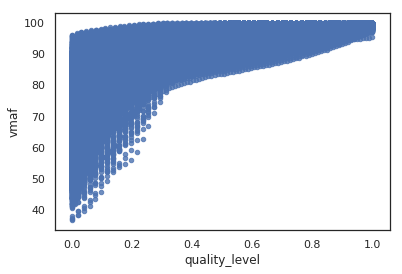

In [11]:

df = pd.read_csv("image_metrics.csv.gz")
print(len(df), len(set(df["image"].values)))
d(df.head())


df.plot(x="quality_level", y="vmaf", kind="scatter", alpha=0.8)

0.9683253451140128
0.6759971161138363
0.5276307570332014
0.6973185883104484


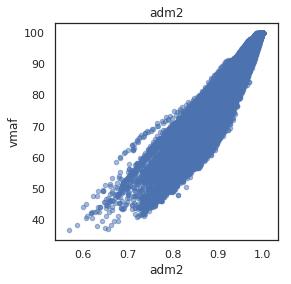

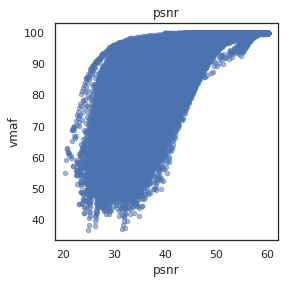

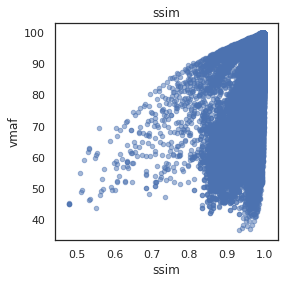

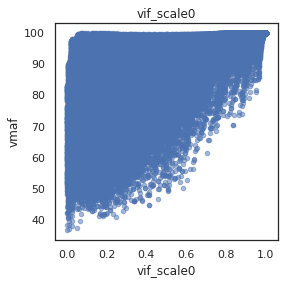

In [12]:
os.makedirs("figures", exist_ok=True)

def save_fig(ax, name):
    ax.get_figure().savefig("figures/" + name , bbox_inches='tight')
    

for x in ["adm2", "psnr", "ssim", "vif_scale0"]:
    print(df[[x, "vmaf"]].corr()["vmaf"][0])
    ax = df[[x, "vmaf"]].plot(kind="scatter", x=x, y="vmaf", title=x, figsize=(4,4), alpha=0.5)
    save_fig(ax, x + "_" + "vmaf_scatter.pdf")

    



/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


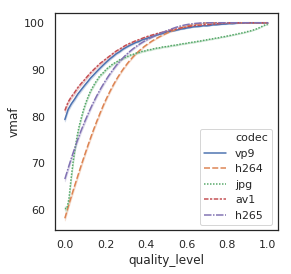

In [40]:
sns.set(rc={
    'figure.figsize':(4,4),
})


sns.set_style("white")


ax = sns.lineplot(
    x="quality_level", 
    y="vmaf",
    hue="codec",
    data=df, ci=95, style="codec", dashes=True, 
)

#ax.set_yscale('log')
"""

dashes=#, markers=True
"""

save_fig(ax, "ql_vmaf.pdf")

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


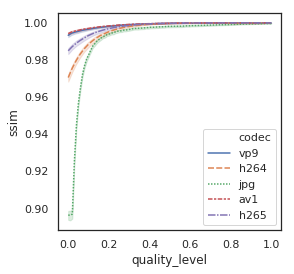

In [41]:
sns.set(rc={'figure.figsize':(4,4)})
sns.set_style("white")
ax = sns.lineplot(
    x="quality_level", 
    y="ssim",
    hue="codec",
    data=df, ci=95, style="codec", dashes=True
)
save_fig(ax, "ql_ssim.pdf")

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


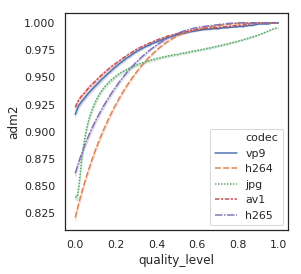

In [42]:
sns.set(rc={'figure.figsize':(4,4)})
sns.set_style("white")
ax = sns.lineplot(
    x="quality_level", 
    y="adm2",
    hue="codec",
    data=df, ci=95, style="codec", dashes=True
)

save_fig(ax, "ql_adm2.pdf")

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


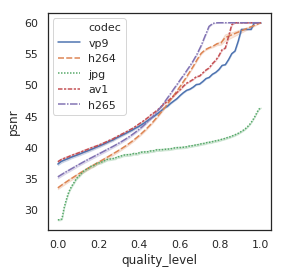

In [43]:
sns.set(rc={'figure.figsize':(4,4)})
sns.set_style("white")
ax = sns.lineplot(
    x="quality_level", 
    y="psnr",
    hue="codec",
    data=df, ci=95, style="codec", dashes=True
)

save_fig(ax, "ql_psnr.pdf")

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


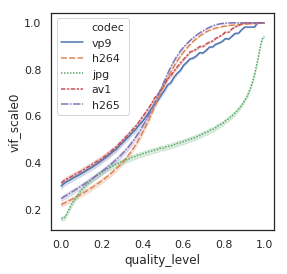

In [50]:
sns.set(rc={'figure.figsize':(4,4)})
sns.set_style("white")
ax = sns.lineplot(
    x="quality_level", 
    y="vif_scale0",
    hue="codec",
    data=df, ci=95, style="codec", dashes=True
)

save_fig(ax, "ql_vif.pdf")

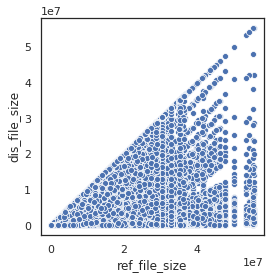

In [45]:
ax = sns.scatterplot(x="ref_file_size", y="dis_file_size", data=df)

save_fig(ax, "size_cmp.pdf")

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


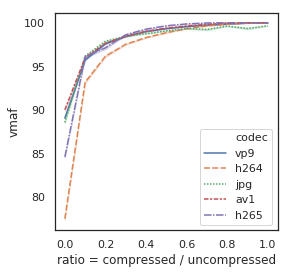

In [56]:

df["compression_ratio_r"] = df["compression_ratio"].round(1)

ax = sns.lineplot(
    x="compression_ratio_r", 
    y="vmaf",
    hue="codec",
    data=df, style="codec", dashes=True
)

ax.set_xlabel("ratio = compressed / uncompressed")

save_fig(ax, "comp_vmaf.pdf")

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


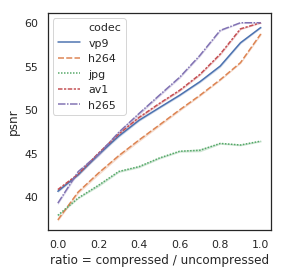

In [57]:
ax = sns.lineplot(
    x="compression_ratio_r", 
    y="psnr",
    hue="codec",
    data=df, style="codec", dashes=True
)

ax.set_xlabel("ratio = compressed / uncompressed")
save_fig(ax, "comp_psnr.pdf")

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


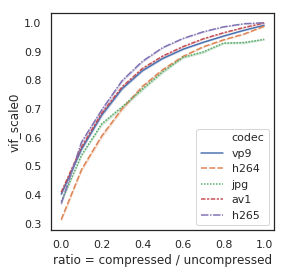

In [58]:
ax = sns.lineplot(
    x="compression_ratio_r", 
    y="vif_scale0",
    hue="codec",
    data=df, style="codec", dashes=True
)

ax.set_xlabel("ratio = compressed / uncompressed")
save_fig(ax, "comp_vif.pdf")

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


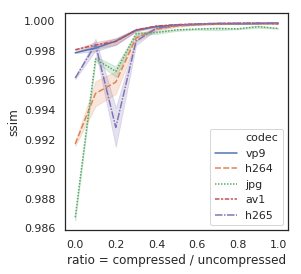

In [59]:
ax = sns.lineplot(
    x="compression_ratio_r", 
    y="ssim",
    hue="codec",
    data=df, style="codec", dashes=True
)

ax.set_xlabel("ratio = compressed / uncompressed")
save_fig(ax, "comp_ssim.pdf")